In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyspark tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

              Price          Open          High           Low           Vol  \
count   2001.000000   2001.000000   2001.000000   2001.000000  2.001000e+03   
mean   18174.069015  18183.756022  18481.333083  17892.956222  1.066544e+07   
std     9524.580025   9541.058407   9726.541865   9348.449629  9.222910e+06   
min     6264.400000   6318.900000   6482.300000   6046.500000  6.682300e+05   
25%    10660.300000  10687.300000  10833.000000  10579.200000  3.250000e+06   
50%    14593.600000  14567.600000  14813.300000  14358.300000  7.530000e+06   
75%    21650.000000  21700.000000  22050.000000  21200.000000  1.613000e+07   
max    49668.900000  50468.500000  51268.200000  48869.200000  6.956000e+07   

          Change %  
count  2001.000000  
mean      0.098051  
std       2.490189  
min      -7.000000  
25%      -1.020000  
50%       0.000000  
75%       1.230000  
max       8.860000  


C:\Users\FPT\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 0.47250473499298096
Epoch [20/50], Loss: 0.10862720757722855
Epoch [30/50], Loss: 0.03718390315771103
Epoch [40/50], Loss: 0.016209028661251068
Epoch [50/50], Loss: 0.010507576167583466
Mean Squared Error on Test Data: 0.0008111307979561388


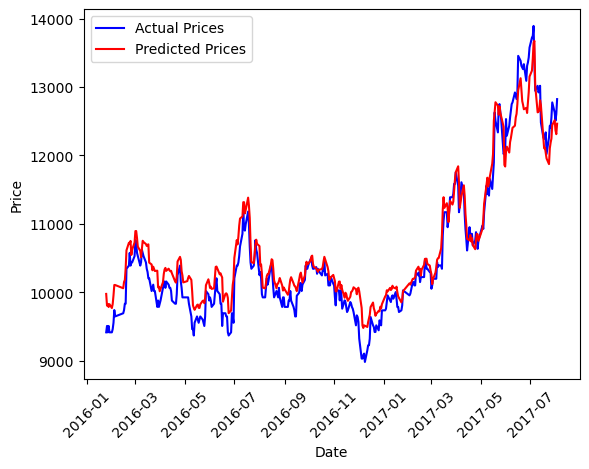

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ CSV
df = pd.read_csv("SSIHistoricalData.csv")

# Tiền xử lý dữ liệu
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
selected_columns = ["Price", "Open", "High", "Low", "Vol", "Change %"]

# Chuyển đổi kiểu dữ liệu và chuẩn hóa
df["Vol"] = df["Vol"].replace({',': ''}, regex=True).replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Xử lý cột "Change %"
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Xử lý các cột số có dấu phẩy
numeric_columns = ["Price", "Open", "High", "Low", "Vol"]
df[numeric_columns] = df[numeric_columns].replace({',': ''}, regex=True).astype(float)

# Tóm tắt thống kê của DataFrame
summary = df.describe()
print(summary)

# Chuẩn hóa giá trị
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_columns])

# Chuẩn bị dữ liệu cho mô hình LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length-1:i+seq_length, 0]  # Dự đoán giá trị "Price"
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 100  # Độ dài của mỗi chuỗi
X, y = create_sequences(scaled_data, seq_length)

# Chia thành tập huấn luyện và tập kiểm thử
test_size = int(len(X) * 0.2)
X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

# Chuyển đổi thành PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Định nghĩa mô hình LSTM để dự đoán giá trị "Price"
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Tạo và huấn luyện mô hình LSTM mới
input_size = X_train_tensor.shape[2]
output_size = 1  # Dự đoán chỉ cột "Price"
hidden_size = 100
dropout_rate = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_rate)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Dự đoán trên tập kiểm thử
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor[:, 0], test_outputs[:, 0])
    print(f'Mean Squared Error on Test Data: {mse}')

# Tính toán giá trị trung bình và độ lệch chuẩn của dữ liệu gốc
original_means = df[selected_columns].mean().values
original_stds = df[selected_columns].std().values

# Chuẩn hóa ngược lại giá trị của y_test
y_test_original = (y_test[:, 0] * original_stds[0]) + original_means[0]

# Chuẩn hóa ngược lại giá trị của test_outputs
test_outputs_original = (test_outputs[:, 0] * original_stds[0]) + original_means[0]

# Hiển thị trên đồ thị
plt.plot(df.index[-len(y_test):], y_test_original, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], test_outputs_original, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [12]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


C:\Users\FPT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\FPT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\FPT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\FPT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\FPT\anaconda3\Lib\site-packages\s

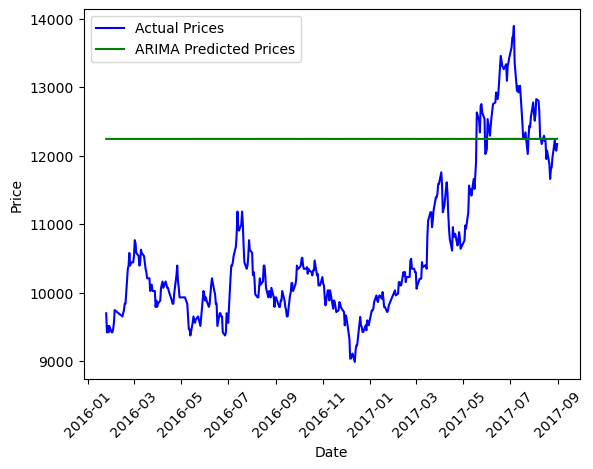

Mean Squared Error (ARIMA) on Test Data: 3847829.846836096


In [22]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the "Price" column
price_column = 'Price'
y = df[price_column]

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Build the ARIMA model
order = (2, 1, 1)  # Choose appropriate values for p, d, and q
model = ARIMA(train, order=order)

# Train the ARIMA model
fit_model = model.fit()

# Make predictions on the test set
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Plot the results
plt.plot(df.index[train_size:], test.values, label='Actual Prices', color='blue')
plt.plot(df.index[train_size:], predictions, label='ARIMA Predicted Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate the model using Mean Squared Error (MSE)
mse_arima = mean_squared_error(test, predictions)
print(f'Mean Squared Error (ARIMA) on Test Data: {mse_arima}')


In [37]:
pip install cython

  Obtaining dependency information for cython from https://files.pythonhosted.org/packages/85/7d/58635941dfbb5b4e197adb88080b9cbfb230dc3b75683698a530a1989bdb/Cython-3.0.8-cp311-cp311-win_amd64.whl.metadata
  Using cached Cython-3.0.8-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
    --------------------------------------- 0.1/2.8 MB 812.7 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 1.5 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/2.8 MB 2.8 MB/s eta 0:00:01
   -------- ------------------------------- 0.6/2.8 MB 3.2 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.8 MB 4.4 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 4.7 MB/s eta 0:00:01
   -------------------------- ------------- 1.9/2.8 MB 5.4 MB/s eta 0:00:01
   ------------------------------- -------- 2.2/2.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
